# Implementation Of The Example Workflow

To get used to the data of this challenge, and to catch a view of where this challenge will challenge us, I came up with a simple implementation of the example workflow proposed by Chris [here][1].

May be a bit late for the party, but, if anyone has suggestions or concerns, I'd be more than happy to assist.

[1]: https://www.kaggle.com/center-for-policing-equity/data-science-for-good/discussion/67450

In [1]:
# imports

import fiona
import matplotlib.pyplot as plt
import pandas as pd
from geopandas.plotting import plot_polygon_collection
from shapely.geometry import shape

In [2]:
# tools

# EEPSG:102003 USA_Contiguous_Albers_Equal_Area_Conic
equal_area_proj = ('+proj=aea'
                   ' +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96'
                   ' +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs ')

def project(geom, p1, p2=equal_area_proj):
    """Convert geom from p1 to p2
    
    Parameters
    ----------
    geom: shapely geometry object
    p1: str or dict
        Parameters for the original projection
    p2: str or dict
        Parameters for the desired projection
        
    Returns
    -------
    shapely geometry object
        An object equivalent to geom, but
        projected into p2 instead
    """
    import pyproj
    from functools import partial    
    from shapely.ops import transform
    
    p1 = pyproj.Proj(p1, preserve_units=True)
    p2 = pyproj.Proj(p2, preserve_units=True)
    project = partial(pyproj.transform, p1, p2)
    transformed = transform(project, geom)
    return transformed

# Police District

First, we need to retrieve the geometry for the police district.

Since we have no data for Providence, let's use Boston (arbitrarily) instead.

![](https://upload.wikimedia.org/wikipedia/en/b/b7/Boston_Police_patch.jpg)

In [3]:
# retrieve district geometry and properties

loc = '../../data/departments/11-00091/external/shapefiles'
with fiona.open(loc) as c:
    rec = next(iter(c))  # choose first district of the list
    crs = c.crs  # coordinate reference system

In [4]:
rec['properties']

OrderedDict([('DISTRICT_I', 0.0),
             ('ID', 'D14'),
             ('DISTRICT', 'D14'),
             ('SHAPE_area', 123631015.285),
             ('SHAPE_len', 58042.1488028)])

We chose district 14. Let's plot its shape using shapely.

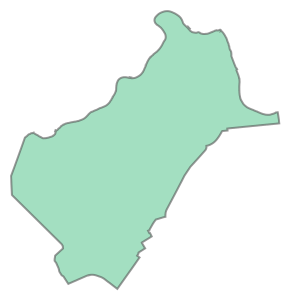

In [5]:
d14_shape = shape(rec['geometry'])
d14_shape = project(d14_shape, crs)  # project into equal-area
d14_shape

Nice...

Now that we have the shape for the district, let's focus on the census tracts.

# Census tracts

The census tracts (from the ACS) were retrieved in [this location][1]. It is a simplified version, so and we will probably want to use the [TIGER][2] later.

[1]: https://www.census.gov/geo/maps-data/data/tiger-cart-boundary.html
[2]: https://www.census.gov/geo/maps-data/data/tiger.html

In [6]:
# retrieve census tracts shapes and properties

loc = '../../data/census/2015/shapefiles/massachusetts'
with fiona.open(loc) as c:
    records = list(c)  # retrieve all tracts from shapefile
    crs = c.crs  # coordinate reference system
print(f"{len(records)} census tracts available")

1475 census tracts available


In [7]:
# set shapely ``shape`` in each record

for record in records:
    record['shape'] = shape(record['geometry'])
    # project into equal-area
    record['shape'] = project(record['shape'], crs)

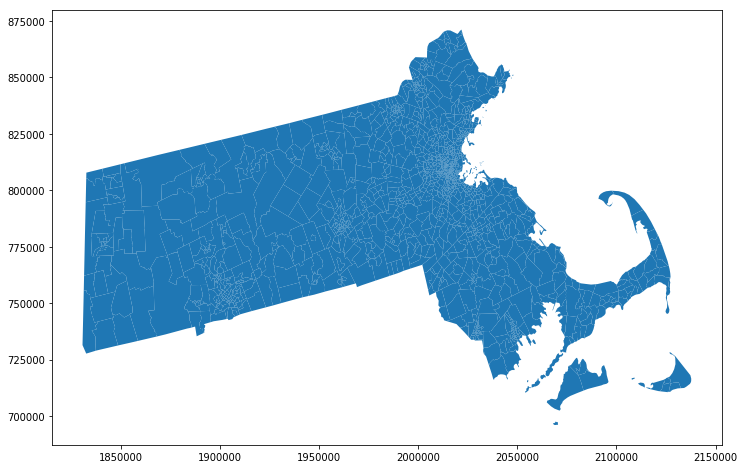

In [8]:
# plot census tracts

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

polygons = [r['shape'] for r in records]
plot_polygon_collection(ax, polygons);

# Combining the shapes

Now let's combine the shapes from the tracts with the shape from the district. We want to know what percentage of each census tract is part of the specified district.

To store this data, we will use a vanilla dictionary.

In [9]:
percentages = {}

for record in records:
    id = record['properties']['AFFGEOID']
    intersection = record['shape'].intersection(d14_shape)
    percentage = intersection.area / record['shape'].area
    percentages[id] = percentage
    
list(percentages.items())[:5]

[('1400000US25001013300', 0.0),
 ('1400000US25003900300', 0.0),
 ('1400000US25003921500', 0.0),
 ('1400000US25005610203', 0.0),
 ('1400000US25005631600', 0.0)]

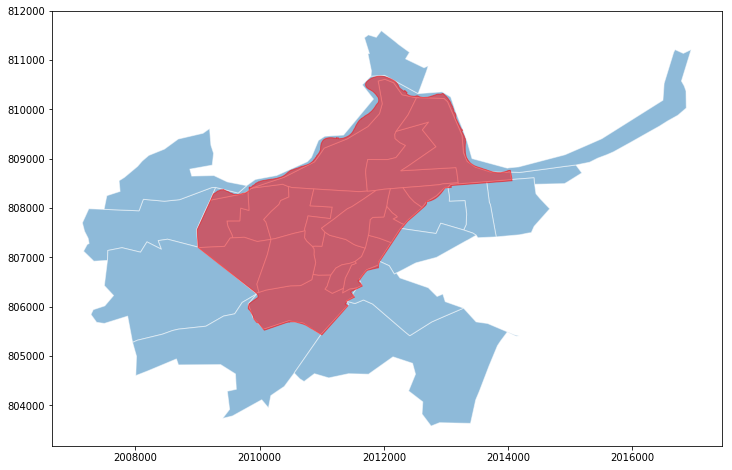

In [10]:
# plot the intercepting census tracts

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

tracts = [r['shape'] for r in records
          if percentages[r['properties']['AFFGEOID']] > 0]
plot_polygon_collection(ax, tracts, edgecolor='white', alpha=0.5)
plot_polygon_collection(ax, [d14_shape], color='red', alpha=0.5)

# Calculation

Okay. Now we calculate the total amount of people and the total amount of black people in the dstrict. The assumption made here is that the total amount of people in a subregion of a tract is proportional to the subregion's size.

We start by loading the census data:

In [11]:
loc = '../../data/departments/11-00091/external/ACS/ACS_15_5YR_DP05_with_ann.csv'
df = pd.read_csv(loc, skiprows=[1])  # there are 2 header rows
df = df.set_index('GEO.id')  # prepare for joining
df.head()

,GEO.id2,GEO.display-label,HC01_VC03,HC02_VC03,HC03_VC03,HC04_VC03,HC01_VC04,HC02_VC04,HC03_VC04,HC04_VC04,...,HC03_VC108,HC04_VC108,HC01_VC109,HC02_VC109,HC03_VC109,HC04_VC109,HC01_VC110,HC02_VC110,HC03_VC110,HC04_VC110
GEO.id,,,,,,,,,,,,,,,,,,,,,
1400000US25025000100,25025000100,"Census Tract 1, Suffolk County, Massachusetts",3671,364,3671,(X),1827,289,49.8,4.9,...,2704,(X),1327,292,49.1,6.6,1377,182,50.9,6.6
1400000US25025000201,25025000201,"Census Tract 2.01, Suffolk County, Massachusetts",3284,325,3284,(X),1494,218,45.5,4.7,...,2727,(X),1250,209,45.8,5.5,1477,208,54.2,5.5
1400000US25025000202,25025000202,"Census Tract 2.02, Suffolk County, Massachusetts",3587,493,3587,(X),1737,293,48.4,5.2,...,2886,(X),1435,253,49.7,5.4,1451,191,50.3,5.4
1400000US25025000301,25025000301,"Census Tract 3.01, Suffolk County, Massachusetts",2712,367,2712,(X),1411,339,52.0,7.3,...,2101,(X),1000,269,47.6,8.4,1101,168,52.4,8.4
1400000US25025000302,25025000302,"Census Tract 3.02, Suffolk County, Massachusetts",2880,353,2880,(X),1182,259,41.0,5.5,...,2218,(X),898,221,40.5,7.0,1320,171,59.5,7.0


Then, we estimate the population contribution of each tract (both for black and total people):

In [12]:
###
# Estimate; RACE - Race alone or in combination with one or more other races - Total population - Black or African American
black_varname = 'HC01_VC79'

# Estimate; RACE - Race alone or in combination with one or more other races - Total population
total_varname = 'HC01_VC77'
###

# join percentage values
pct_series = pd.Series(percentages)
pct_series.name = 'percentage'
small = df[[black_varname, total_varname]].join(pct_series, how='left')

# estimate populations inside police district
small['black_pop'] = small[black_varname] * small['percentage']
small['total_pop'] = small[total_varname] * small['percentage']

small.head()

,HC01_VC79,HC01_VC77,percentage,black_pop,total_pop
GEO.id,,,,,
1400000US25025000100,179,3671,1.000000,179.000000,3671.000000
1400000US25025000201,189,3284,1.000000,189.000000,3284.000000
1400000US25025000202,385,3587,1.000000,385.000000,3587.000000
1400000US25025000301,50,2712,0.999990,49.999490,2711.972329
1400000US25025000302,164,2880,0.997813,163.641405,2873.702720


And, to finalize, we estimate the amount of black people and the total amount of people in the police district, by summing the contributions from each tract:

In [13]:
black_pop = small['black_pop'].sum()
total_pop = small['total_pop'].sum()

In [14]:
print(f"Estimated black population: {black_pop:.1f}")
print(f"Estimated total population: {total_pop:.1f}")
print(f"Estimated percentage: {black_pop / total_pop:.1%}")

Estimated black population: 4252.2
Estimated total population: 67378.0
Estimated percentage: 6.3%
